In [21]:
import numpy as np
import scipy as sci
import tensorflow as tf
import qutip as qt
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)



import os
from ADDissipativeEngineering import ADDissipativeEngineering
import joblib
from joblib import Parallel, delayed
import time
num_qubits = 3
diss_span = 3
AD = ADDissipativeEngineering(num_qubits=num_qubits, dissipator_span=diss_span, data="real")


In [31]:
targ_state_name = 'W_Real'
path = os.getcwd()+'/Reported_Results/'+targ_state_name+'/'+'N_{}_DissSpan_{}/'.format(num_qubits, diss_span)
if not os.path.isdir(path):
    os.makedirs(path)

super_1  = qt.ket('01') 
super_2  = qt.ket('10')
GHZ5  = (qt.ket("00000") + qt.ket("11111"))/np.sqrt(2)
GHZ3 = (qt.ket('000') + qt.ket('111') )/np.sqrt(2)
GHZ2 = (qt.ket('00') + qt.ket('11') )/np.sqrt(2)
Bell00 = (qt.ket('00') + qt.ket('11') )/np.sqrt(2)
W2 = (qt.ket('01') + qt.ket('10') )/np.sqrt(2)
W3 = (qt.ket('001') + qt.ket('010') + qt.ket('100'))/np.sqrt(3)
GHZ4 = (qt.ket('0000') + qt.ket('1111') )/np.sqrt(2)
W4 = (qt.ket('0001') + qt.ket('0010') + qt.ket('0100') + qt.ket('1000'))/np.sqrt(4)
r = 3/4
MEMS1 = (r/2)*(qt.projection(4,0,3) + qt.projection(4,3,0) + qt.projection(4,0,0) + qt.projection(4,3,3)) + (1-r)*qt.projection(4,1,1)
MEMS2 = (r/2)*(qt.projection(4,0,3) + qt.projection(4,3,0)) + (1/3)*(qt.projection(4,1,1)+ qt.projection(4,0,0) + qt.projection(4,3,3))
theta1=np.pi
theta2 = np.pi
theta3 = np.pi
theta4 = np.pi
init_state = qt.ket('000')
plusX4 = qt.hadamard_transform(N=3)*init_state 
CP1 = qt.cphase(theta1, N=3, control=0, target=1)
CP2 = qt.cphase(theta2, N=3, control=1, target=2)
CP3 = qt.cphase(theta3, N=3, control=2, target=0)
# CP4 = qt.cphase(theta4, N=4, control=3, target=0)
cluster = (CP1 * CP2 * CP3 * plusX4)


In [33]:
size = AD.local_basis_size - 1
batch_size=1
if AD.data=="real":
    shape = (batch_size, AD.N_dissipators, int((size*(size+1))/2))
    np_save_shape = batch_size*AD.N_dissipators*int((size*(size+1))/2)
else:
    shape = (batch_size, AD.N_dissipators, size, size)
    np_save_shape = batch_size*AD.N_dissipators*size*size
size = AD.local_basis_size-1
# targ_state = targ_state_pure * targ_state_pure.dag()
targ_state = W3*W3.dag()
best_path = path + 'Best/'
Diss_Vars = np.loadtxt(best_path+'Best_Diss_Vars').reshape(shape)
# H_Vars = tf.ones(batch_size, (2 * AD.N_qubits + AD.N_couple))
cost = np.loadtxt(best_path+'Full_Cost')
c_mat = AD.build_A(tf.Variable(Diss_Vars, dtype=tf.float64))
Diss = AD.build_dissipator(c_mat)*100
Liouv = tf.math.real(Diss)
Liouv_qt = qt.Qobj(Liouv[0].numpy(), type='super')
rho_ss = qt.steadystate(Liouv_qt)

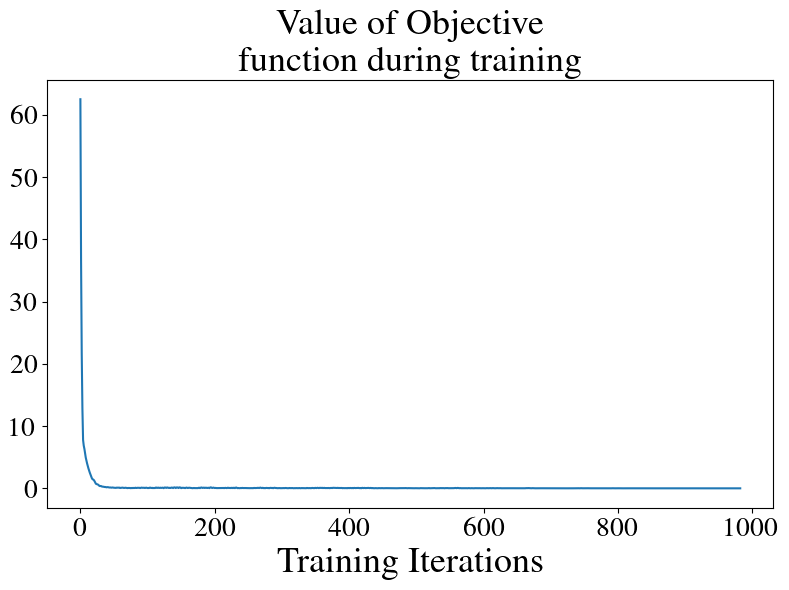

In [34]:
plt.figure(10101, figsize=(8,6), layout="tight")
# plt.plot(np.log2(np.array(cost)), color="grey", alpha=0.8, label = "log")
plt.plot(np.array(cost), alpha=1.)
plt.title("Value of Objective \n function during training", fontsize = 26)
# plt.title(r"Logarithmic scale", fontsize = 26)
plt.xlabel("Training Iterations", fontsize = 26)
plt.tick_params(axis='both',labelsize=20)
np.argmin(np.array(cost))/50
plt.savefig(path+"TraingCurve", dpi=600)
# plt.savefig(path+"TraingCurveLog", dpi=600)

In [35]:
# basis_labels = [r"$S_{{{}}}$".format(str(i)) for i in range(1,AD.local_basis_size)]
basis_labels = AD.label_ls[1:]
# basis_labels

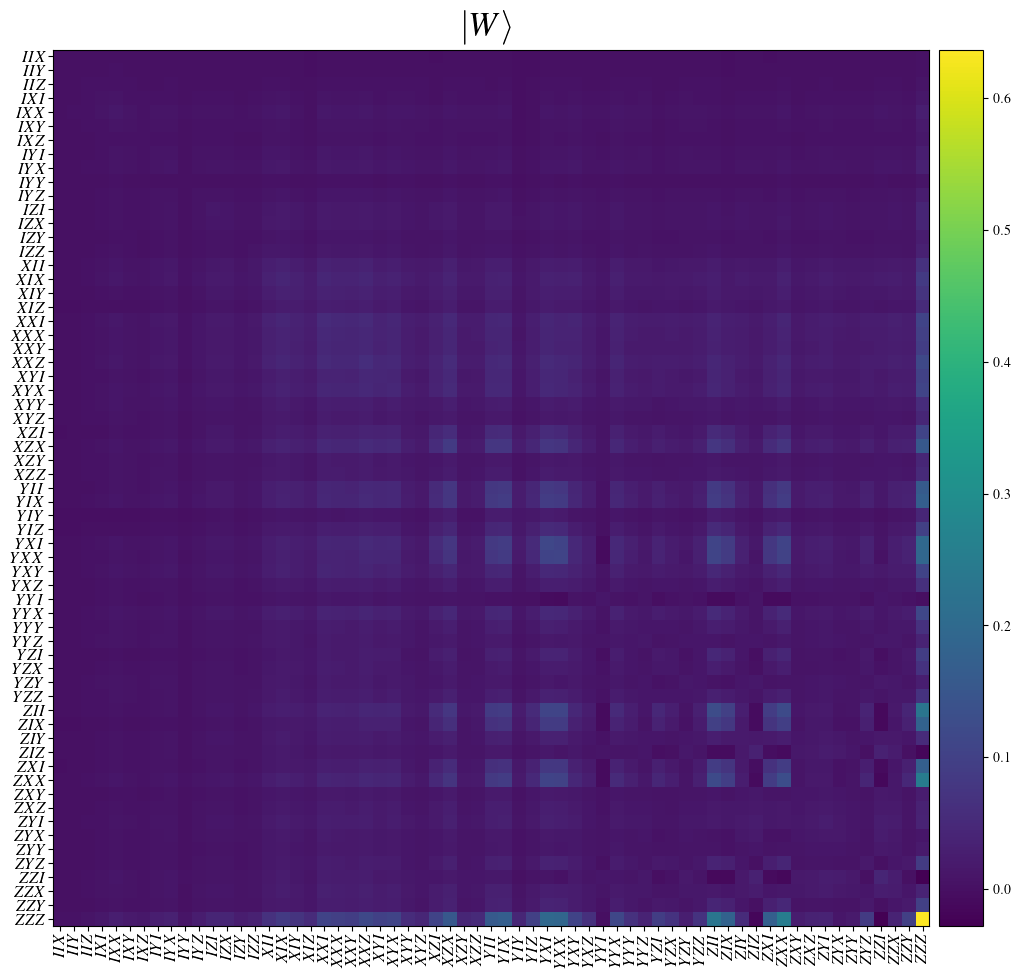

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(AD.N_dissipators, figsize=(12,AD.N_dissipators*12))
im_real = []
im_imag =[]
for i in range(AD.N_dissipators):
    if AD.N_dissipators==1:
        im1 = axs.imshow(c_mat[0,i].numpy().real/AD.g_max, cmap='viridis')
        axs.set_title(r"$|W\rangle$", fontsize=25, pad=10.)
        axs.set_xticks(np.arange(AD.local_basis_size-1), basis_labels, fontsize=12,  rotation='vertical')
        axs.set_yticks(np.arange(AD.local_basis_size-1), basis_labels, fontsize=12)
        divider = make_axes_locatable(axs)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im1, cax=cax, orientation='vertical')    
    else:
        im_real.append(axs[i].imshow(c_mat[0,i].numpy().imag/AD.g_max, cmap='viridis'))
        axs[i].set_title("Dissipator Spanning {} Real Elements".format(AD.diss_indices[i]), fontsize=20)
        axs[i].set_xticks(np.arange(AD.local_basis_size-1), basis_labels, fontsize=13)
        axs[i].set_yticks(np.arange(AD.local_basis_size-1), basis_labels, fontsize=13)
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes('right', size=0.1, pad=0.1)
        fig.colorbar(im_real[i], cax=cax, orientation='vertical')
        
plt.savefig(path + "Dissipator_Values", dpi=600)

In [14]:
idxs = np.nonzero(np.abs(c_mat[0,0])>0.05)

L_is = np.array(AD.label_ls[1:])[idxs[0].astype(np.int32)]
L_js = np.array(AD.label_ls[1:])[idxs[1].astype(np.int32)]
opers = list(zip(L_is,L_js))
opers

[('$X$$X$', '$X$$X$'),
 ('$X$$X$', '$Z$$Z$'),
 ('$Y$$Y$', '$Z$$Z$'),
 ('$Z$$I$', '$Z$$Z$'),
 ('$Z$$Z$', '$X$$X$'),
 ('$Z$$Z$', '$Y$$Y$'),
 ('$Z$$Z$', '$Z$$I$'),
 ('$Z$$Z$', '$Z$$Z$')]

In [543]:
# # Rescale the number of parameters
# max_num_params = np.max(np.array(num_params))
# min_num_params = np.min(np.array(num_params))
# range_labels = np.linspace(min_num_params, max_num_params,5)
# ran = np.max(fidelities) - np.min(fidelities)
# rescaled_params = (np.array(num_params)/max_num_params) * ran


# fig, host = plt.subplots(figsize=(10,6)) # (width, height) in inches
# # (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)

# par1 = host.twinx()

# par1.set_ylim(min_num_params, max_num_params+20)
# host.set_title("Fidelity loss with increasing \n Parameter Removal.", fontsize=20)
# host.set_xlabel("Threshold value for parameter removal \n /Maximum parameter value", fontsize=20)
# host.set_ylabel("Fidelity", fontsize=25)
# par1.set_ylabel("Number of \n removed Parameters", fontsize=20)



# p1 = host.scatter(threshold_percent_ls, fidelities, linewidth=0.5, color=colors,  
#                   label="Fidelity", marker="x")
# p2 = par1.scatter(threshold_percent_ls, np.array(num_params), color='orange', linewidth=0.5,
#                 label="Parameters removed", marker="x")

# lns = [p1, p2]
# host.legend(handles=lns, loc=(0.5, 0.8), fontsize=15)

# # Sometimes handy, same for xaxis
# #par2.yaxis.set_ticks_position('right')

# # Move "Velocity"-axis to the left
# # par2.spines['left'].set_position(('outward', 60))
# # par2.spines['left'].set_visible(True)
# # par2.yaxis.set_label_position('left')
# # par2.yaxis.set_ticks_position('left')

# # host.yaxis.label.set_color(p1.get_color())
# # par1.yaxis.label.set_color(p2.get_color())

# # Adjust spacings w.r.t. figsize
# # fig.tight_layout(pad =0.5)
# # host.text(x=0.05, y=0.97, s="{}".format(np.round(fidelities[43], decimals=4)), fontsize=16)
# # host.text(x=0.044, y=0.58, s="{}".format(num_params[43]), fontsize=16)
# # host.text(x=0.05, y=0.75, s="Maximum \n Fidelity: {}".format(np.max(np.round(fidelities, decimals=4))), fontsize=16)
# # plt.axvspan(0, 0.043, color='green', alpha=0.3)

# plt.savefig(path + "Fidelity_for_param_removal", 
#             dpi=600, layout="tight")

(<Figure size 1000x1000 with 2 Axes>, <Axes3D: >)

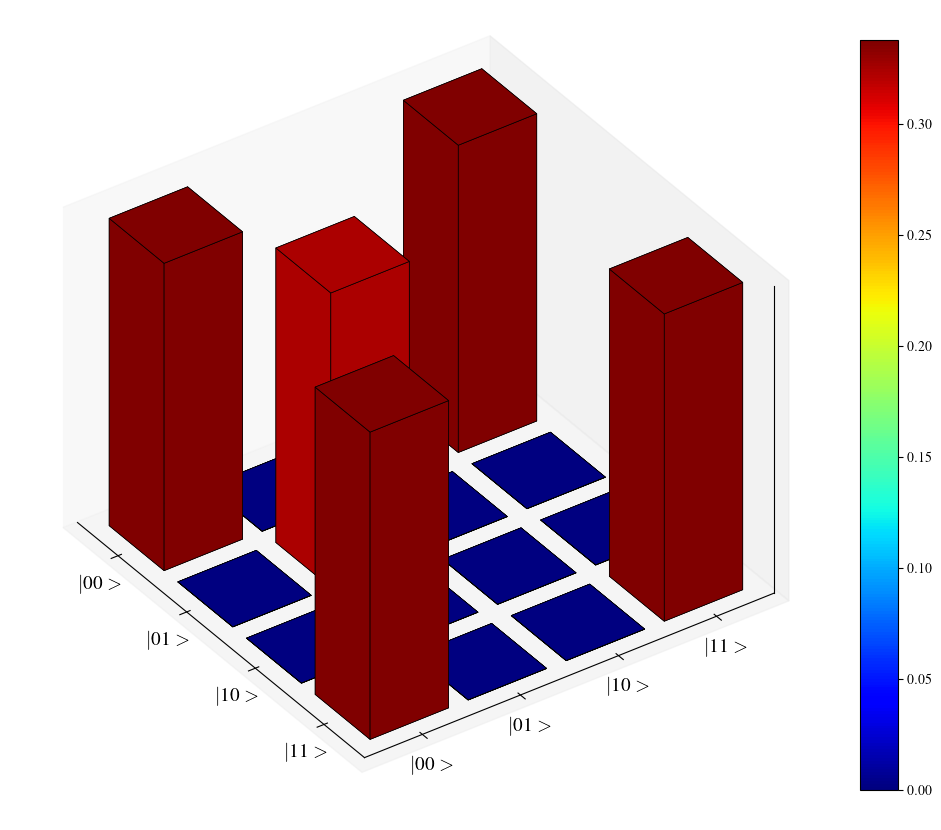

In [554]:
labels = [r"$|{}>$".format(np.binary_repr(i, width=num_qubits)) for i in range(2**num_qubits)]

opts={'figsize':(10,10)}
qt.matrix_histogram(rho_ss.full().real, options=opts,
                   xlabels=labels, ylabels=labels)

1.0000000765548482

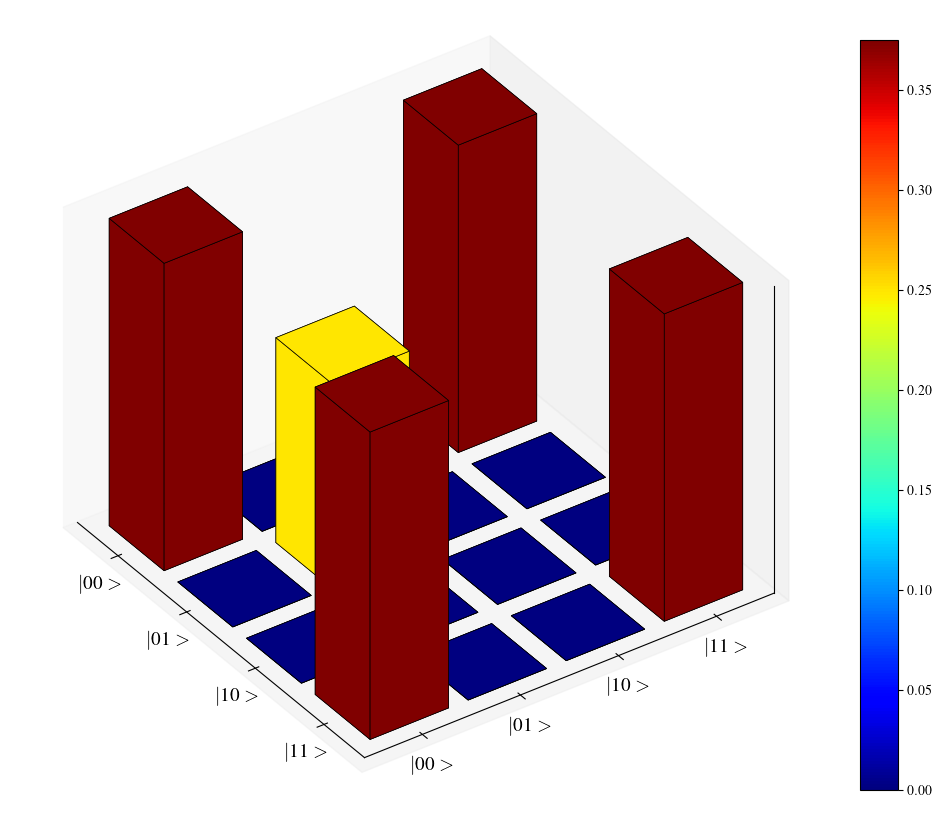

In [555]:
# targ_dm = targ_state_pure * targ_state_pure.dag()
# targ_state = qt.Qobj(targ_dm.full())

qt.matrix_histogram(targ_state.full().real, options=opts,
                   xlabels=labels, ylabels=labels)

rho_ss.tr()

In [556]:
qt.fidelity(qt.Qobj(targ_state.full()), rho_ss)

0.9966044859610648

In [557]:
print(AD.positivity_check(c_mat))
print(AD.hermicity_check(c_mat))

True
True


In [548]:
"""
Solving the dynamics.
"""
# threshold_percent = 0
# c_mat_copy = c_mat
# thresh = threshold_percent * np.max(np.abs(c_mat_copy))
# c_mat_copy[np.abs(c_mat_copy)<thresh] = 0.0
# count = c_mat_copy[np.abs(c_mat_copy)<thresh].shape[0]
# c_mat_ls_filtered.append(tf.Variable(c_mat_copy))
# truth = AD.positivity_check(c_mat_ls_filtered[0])
# counts.append(count)
# print(tf.linalg.eigvals(c_mat_ls_filtered[0]))
Diss = AD.build_dissipator(c_mat)
Liouv = Diss
Liouv_qt = qt.Qobj(Liouv[0].numpy(), type='super')
rho = qt.rand_dm(N=2**num_qubits, dims=rho_ss.dims)
time = np.linspace(0,1000,1000)
res = qt.mesolve(H=Liouv_qt, rho0=rho, tlist=time)

trace: 0.9999983286119416
eigenvalues: [2.86364695e-05 6.56910287e-05 3.87572344e-01 6.12331657e-01]


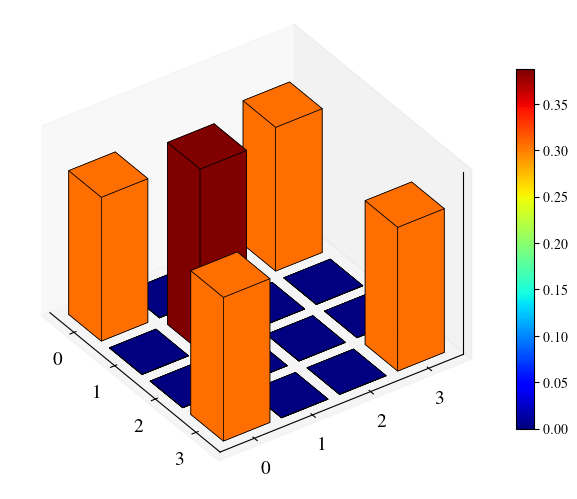

In [549]:
qt.matrix_histogram(res.states[-1])
print("trace: {}".format(res.states[-1].tr()))
print("eigenvalues: {}".format(res.states[-1].eigenenergies()))

In [550]:
populations = np.zeros((2**AD.N_qubits, 1000))
for i in range(1000):
    populations[:,i] = res.states[i].diag()[:]

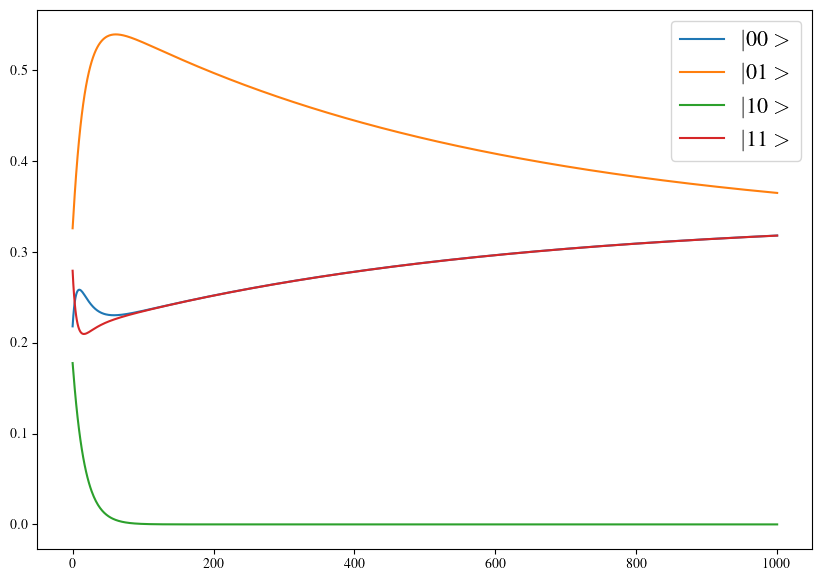

In [503]:
fig = plt.figure(111, figsize=(10,7))
for i in range(2**AD.N_qubits):
    plt.plot(time, populations[i,:], label = labels[i])
plt.legend(fontsize=16)

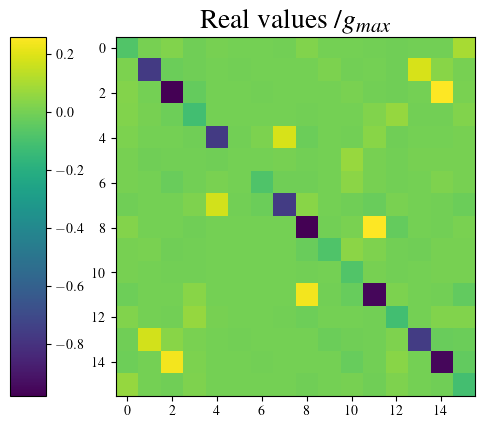

In [504]:
fig, axs = plt.subplots(1, figsize=(6,6))
im1 = axs.imshow(Diss[0].numpy().real, cmap='viridis')
axs.set_title(r"Real values /$g_{max}$", fontsize=20)
divider = make_axes_locatable(axs)
cax = divider.append_axes('left', size='10%', pad=0.7)
fig.colorbar(im1, cax=cax, orientation='vertical')

In [2]:
string(["x","y","z"])

TypeError: unsupported operand type(s) for +: 'int' and 'str'